![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Aggregate GLOFAS discharge into cumulative storage change for the considered river basins

In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import os
import geopandas as gpd
import pandas as pd

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geoslurp import GeoslurpManager
from geoslurp.tools.xarray import *
import geoslurp.tools.pandas
from scipy.integrate import cumulative_trapezoid

#local python tools
from common.config import read_config

In [94]:
conf=read_config()
datadir=conf['dataroot']
glofasfoutlet='glofasv4_outlets.nc'

In [85]:
dsglofasoutl=xr.open_dataset(os.path.join(datadir,glofasfoutlet)).set_coords('basins').set_xindex('basins')

# extract the data for the locations which have the largest upstream area per basin

idx_max=[]
for basin,grp in dsglofasoutl.upstream_area.groupby('basins'):
    idx=grp.argmax().item()
    idx_max.append(grp.noutlets[idx])

dsglofasoutl=dsglofasoutl.isel(noutlets=idx_max).drop_vars('noutlets')

display(dsglofasoutl)

/tmp/ipykernel_23213/359984781.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dsglofasoutl=xr.open_dataset(os.path.join(datadir,glofasfoutlet)).set_coords('basins').set_xindex('basins')


<xarray.Dataset> Size: 5MB
Dimensions:        (time: 9132, noutlets: 121)
Coordinates:
  * time           (time) datetime64[ns] 73kB 2000-01-01 ... 2024-12-31
    step           timedelta64[ns] 8B ...
    surface        float64 8B ...
    latitude       (noutlets) float64 968B ...
    longitude      (noutlets) float64 968B ...
    valid_time     (time) datetime64[ns] 73kB ...
  * basins         (noutlets) <U39 19kB 'AMAZONAS' 'AMUR' ... 'ZAMBEZI'
Dimensions without coordinates: noutlets
Data variables:
    dis24          (time, noutlets) float32 4MB ...
    endo           (noutlets) int64 968B ...
    upstream_area  (noutlets) float64 968B ...

In [97]:
# also compute cumulative integral, mean and climatologies


#compute mean fluxes
dsglofasoutl['dis24_mean']=('noutlets',dsglofasoutl.dis24.mean('time').data)

#cumulative integrations after removing the mean
#delta time since the first epoch as secvonds
deltat=(dsglofasoutl.valid_time-dsglofasoutl.valid_time[0]).astype('timedelta64[s]').astype(int)

delta_dis24=dsglofasoutl.dis24-dsglofasoutl.dis24_mean
dsglofasoutl['dis24_cuma']=(['noutlets','time'],cumulative_trapezoid(y=delta_dis24.data.T,x=deltat,initial=0))

dsglofasoutl['dis24_clima']=dsglofasoutl.dis24.groupby('time.month').mean()
# ds_flux['et_clima']=ds_flux.avg_ie.groupby('time.month').mean()




In [98]:
# save to file
glofas_comb_file=os.path.join(datadir,conf['glofas-comb'])
dsglofasoutl.to_netcdf(glofas_comb_file)


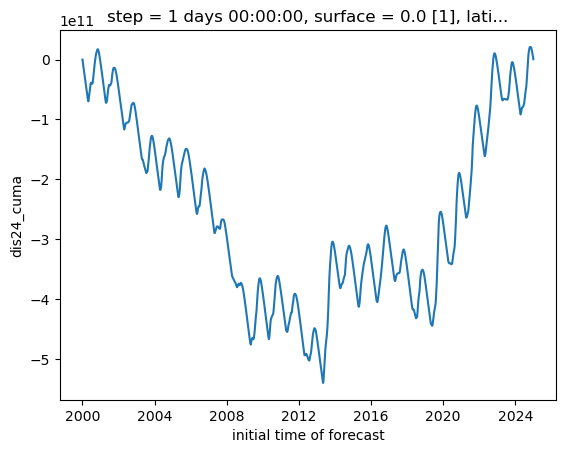

In [100]:
dsbasin=dsglofasoutl.sel(basins='AMUR')

dsbasin.dis24_cuma.plot()
